In [13]:
import matplotlib.pyplot as plt
import os
height = 6
width = height*1.6
plt.rcParams["figure.figsize"] = (width,height)
import numpy as np
plt.style.use('seaborn-colorblind')
import torch
from torch.distributions import Categorical

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# import torch
# from torch.distributions import Categorical

# soft = np.full((10),0.1)
# max_val = Categorical(probs = torch.from_numpy(soft)).entropy().numpy()
# print(max_val)

plt.style.use('seaborn-colorblind')

def load(directory):
    metric_directory = directory+'/metrics/'
    ground_truths = list()
    outputs = list()
    
    for run in range(0,3):
        ground_truth = np.load(metric_directory+'test-ground-truth-run-'+str(run)+'.npy')
        output = np.load(metric_directory+'test-raw-softmax-run-'+str(run)+'.npy')
        ground_truths.append(ground_truth)
        outputs.append(output)
        
    ground_truths = np.array(ground_truths)
    outputs = np.array(outputs)
        
    mac_readings = np.load(directory+'/metrics/layerwise_macs.npy')
    
    return ground_truths,outputs,mac_readings

def get_label(directory):
    model = directory.split('/')[2]
    branch_weights = np.load(directory+"/metrics/branch-weights-"+model+".npy")
    string = model + ' ('
    for weight in branch_weights:
        weight = np.round(weight,decimals=3)
        string = string + str(weight) + " : "
    string = string[:-3]+')'
    return(string)

def get_exit_p(exit_readings):
    
    exit_p = np.zeros(4)

    for exit in range(len(exit_p)): 
        exit_p[exit] = np.count_nonzero(exit_readings==exit)
    return(exit_p/len(exit_readings))

def get_MACs_acc(exits, macs, important, layers):
    layerwise_macs = np.take(macs,important)
        
    powers = np.zeros(4)
    powers[0]  = np.sum(np.take(layerwise_macs,layers[0]))
    powers[1]  = np.sum(np.take(layerwise_macs,layers[1]))
    powers[2]  = np.sum(np.take(layerwise_macs,layers[2]))
    powers[3]  = np.sum(layerwise_macs)

    exit_p = get_exit_p(exits)

    avg_powers = np.sum(np.multiply(exit_p,powers))

    return avg_powers, exit_p

def branch_MACs(directory, runs, important, layers):
    model = directory.split('/')[2]
    _,_, macs = load(directory)
    layerwise_macs = np.take(macs,important)
    label = get_label(directory)
    accuracies = np.load(directory+"/metrics/branch-val-accuracies-"+model+".npy")
    mean_accuracies = np.mean(accuracies,axis=0)
    std_accuracies = np.std(accuracies,axis=0)
    
    accs = np.zeros(4)
    std = np.zeros(4)
    for idx,row in enumerate(mean_accuracies):
        branch_best = np.argmax(row)
        accs[idx] = mean_accuracies[idx,branch_best]
        std[idx] = std_accuracies[idx,branch_best]
        
    powers = np.zeros(4)
    powers[0]  = np.sum(np.take(layerwise_macs,layers[0]))
    powers[1]  = np.sum(np.take(layerwise_macs,layers[1]))
    powers[2]  = np.sum(np.take(layerwise_macs,layers[2]))
    powers[3]  = np.sum(layerwise_macs)
    
    return powers, accs, std, label

In [14]:
def get_plot_values(directory,layers,branches,n_thresh=100):

    label = get_label(directory)

    ground_truths, outputs, power = load(directory)

    runs = outputs.shape[0]
    n_branches = outputs.shape[1]
    n_inputs = ground_truths.shape[1]

    n_classes = outputs.shape[3]
    p = 1.0 /n_classes
    max_entropy = -sum([p * np.log(p) for _ in range(n_classes)])
    print("N Classes: ",n_classes,"\tMax Entropy:",max_entropy)

    thresholds = np.linspace(max_entropy,0,n_thresh)
    accuracies = np.zeros((2,n_thresh))
    MACs = np.zeros((2,n_thresh))
    percentages = np.zeros((n_thresh,n_branches))
    branch_accs = np.zeros((runs,n_branches,n_inputs))
    branch_exits = np.full((n_thresh,runs,n_inputs),n_branches-1)

    for thresh_idx,threshold in enumerate(thresholds):
        thresh_acc = np.zeros(runs)
        thresh_mac = np.zeros(runs)
        thresh_p = np.zeros((runs,n_branches))
        for run in range(runs):
            run_output = outputs[run,:,:,:]
            branch_predictions = np.argmax(run_output,axis=2)
            branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

            entropy = Categorical(probs = torch.from_numpy(run_output)).entropy().numpy()
            N = entropy.shape[1]

            exits = np.full(N,3)
            predictions = np.argmax(run_output[-1,:,:],1)

            for inp_idx, _ in enumerate(ground_truths[0]):
                entropies = entropy[:,inp_idx]
                for branch_idx, branch_entr in enumerate(entropies):
                    if branch_entr < threshold:
                        exits[inp_idx] = branch_idx
                        predictions[inp_idx] = np.argmax(run_output[branch_idx,inp_idx,:])
                        branch_exits[thresh_idx,run,inp_idx] = branch_idx
                        break

            thresh_acc[run] = np.sum(np.equal(ground_truths[run],predictions))/N
            thresh_mac[run], thresh_p[run,:] = get_MACs_acc(exits, power, layers, branches)

        accuracies[0,thresh_idx] = np.mean(thresh_acc)
        accuracies[1,thresh_idx] = np.std(thresh_acc)
        MACs[0,thresh_idx] = np.mean(thresh_mac)
        MACs[1,thresh_idx] = np.std(thresh_mac)

        percentages[thresh_idx,:] = np.mean(thresh_p,axis=0)
    return(accuracies,MACs,percentages,thresholds,label,branch_accs,branch_exits)


def plot_branch_accuracy(branch_accs,exits,thresholds):
    branch_accuracies = np.zeros((branch_accs.shape[0],branch_accs.shape[1],thresholds.shape[0]))
    print(branch_accuracies.shape)
    for run in range(0,branch_accuracies.shape[0]):
        for thresh_idx, _ in enumerate(thresholds):
            for branch in range(0,4):
                exit_idx = np.argwhere(exits[thresh_idx,run,:] == branch)
                branch_accuracies[run,branch,thresh_idx] = np.sum(branch_accs[run,branch,exit_idx])/exit_idx.shape[0]

    mean_accuracies = np.mean(branch_accuracies,axis=0)
    std_accuracies = np.std(branch_accuracies,axis=0)
    return(mean_accuracies,std_accuracies)



In [15]:
#testing with single directory

mobilenet_layers = [2,6,10,16,20,36,48,61,79,98,117,135,154,172,191,210,214,218]
mobilenet_branches = [[0,3,4,5],[0,1,3,4,5,6,7,8],[0,1,2,3,4,6,7,8,9,10,11,12]]

resnet_layers = [1,2,3,16,31,46,61,62,63,64]
resnet_branches = [[0,1,2,6],[0,1,2,3,6,7],[0,1,2,3,4,6,7,8]]

directory = "../trained-models/BranchedResNet18/CIFAR10/wb102-b202-b302/"

accuracies,MACs,percentages,thresholds,label,branch_accs,exits = get_plot_values(directory,resnet_layers,resnet_branches)

N Classes:  10 	Max Entropy: 2.3025850929940455


(3, 4, 100)


/Users/jackdymond/Documents/Work/PhD/Experiments/Class Separation/Code/Class-Separation/environment/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


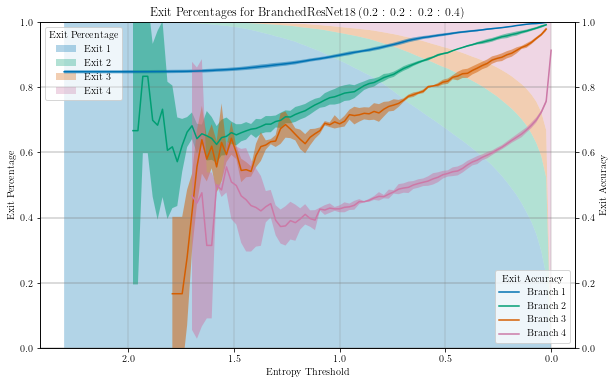

In [16]:
#plotting test results
mean_accuracies, std_accuracies = plot_branch_accuracy(branch_accs,exits,thresholds)
power,branch_base_accs,branch_base_std,label = branch_MACs(directory,3,resnet_layers,resnet_branches)

# print(branch_base_accs)

# plt.plot(MACs[0],accuracies[0],label=label)
# plt.fill_between(MACs[0],accuracies[0]+accuracies[1],accuracies[0]-accuracies[1],alpha=0.4)
# plt.xscale('log')
# plt.grid(color='grey', linestyle='-', linewidth=0.3)
# plt.grid(which='minor',color='lightgrey', linestyle='--', linewidth=0.3)
# plt.legend()
# plt.show()

# plt.plot(thresholds,accuracies[0],label=label)
# plt.fill_between(thresholds,accuracies[0]+accuracies[1],accuracies[0]-accuracies[1],alpha=0.4)
# plt.gca().invert_xaxis()
# plt.legend()
# plt.show()

# plt.plot(MACs[0],thresholds,label=label)
# # plt.fill_between(thresholds,MACs[0]+MACs[1],MACs[0]-MACs[1],alpha=0.4)
# plt.gca().invert_yaxis()
# plt.xscale('log')
# plt.grid(color='grey', linestyle='-', linewidth=0.3)
# plt.grid(which='minor',color='lightgrey', linestyle='--', linewidth=0.3)
# plt.legend()
# plt.show()

#Stackplot for the background
fig, ax1 = plt.subplots()
plt.stackplot(thresholds,percentages.T,labels=['Exit 1','Exit 2','Exit 3','Exit 4'],alpha=0.3)
plt.title('Exit Percentages for ' + label)
plt.ylabel('Exit Percentage')
plt.xlabel('Entropy Threshold')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.ylim(0,1)
plt.legend(title='Exit Percentage',loc=2)
plt.gca().invert_xaxis()

#Add the accuracies on top of the plot - reset colours
ax2 = ax1.twinx()
plt.gca().set_prop_cycle(None)   
for i in range(mean_accuracies.shape[0]):
    plt.plot(thresholds,mean_accuracies[i],label=('Branch '+str(i+1)))
    plt.fill_between(thresholds,mean_accuracies[i,:]+std_accuracies[i,:],mean_accuracies[i,:]-std_accuracies[i,:],alpha=0.5)
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.ylabel('Exit Accuracy')
plt.ylim(0,1)
plt.legend(title='Exit Accuracy',loc=4)
plt.savefig('stackplot.pgf')
plt.show()

# for i in range(mean_accuracies.shape[0]):
#     plt.plot(mean_accuracies[i],percentages.T[i],label=('Branch '+str(i+1)))
# plt.grid(color='grey',linestyle='-',linewidth=0.3)
# plt.ylabel('Exit Percentage')
# plt.xlabel('Exit Accuracy')
# plt.show()


# for i in range(mean_accuracies.shape[0]):
#     plt.plot(thresholds,mean_accuracies[i]-branch_base_accs[i],label=('Branch '+str(i+1)))
#     # plt.fill_between(thresholds,mean_accuracies[i,:]+std_accuracies[i,:],mean_accuracies[i,:]-std_accuracies[i,:],alpha=0.4)
# plt.gca().invert_xaxis()
# plt.grid(color='grey', linestyle='-', linewidth=0.3)
# plt.legend()
# plt.show()


In [17]:
#working out network improvement
print(branch_accs.shape) 
decrease = 0
for inp in range(branch_accs.shape[2]):
    correct = 0
    branch_acc = branch_accs[0,:,inp]
    for branch in branch_acc:
        if branch < correct:
            decrease = decrease + 1
        correct = branch

print(decrease)
    

(3, 4, 10000)
504


In [18]:
#ACCURACY VS MACs

# dataset = 'eurosat-rgb'
# dataset = 'CIFAR10'
dataset = 'CIFAR100'
# dataset = 'sat-6'

simplenet_sat6 = 557875206.0
spectrumnet_dsc = 75.59e6
spectrumnet_standard = 203.47e6
resnet_power_sat6 = 458113542.0
resnet_power_CIFAR = 556651530.0
mobilenet_power_CIFAR = 18582632.0
mobilenet_power_sat6 = 15892068.0

directory = "../trained-models/BranchedMobileNet/"+dataset+"/CA-lr-"
# names = ["wb101-b202-b303","wb102-b202-b302","wb102-b201-b303","wb102-b203-b301"] 
names = ["wb102-b202-b302"]

mobile_net_layers = [2,6,10,16,20,36,48,61,79,98,117,135,154,172,191,210,214,218]
mobile_net_branches = [[0,3,4,5],[0,1,3,4,5,6,7,8],[0,1,2,3,4,6,7,8,9,10,11,12]]

colours = ['orangered','seagreen', 'darkmagenta', 'orange']

mobile_labels = list()

for idx, name in enumerate(names):
    colour = colours[idx]
    plot_directory = directory+name
    accs,MACs,percentages,thresholds,label, branch_accuracies, exits = get_plot_values(plot_directory, mobile_net_layers, mobile_net_branches)
    plt.plot(MACs[0],accs[0],'-',label=label,color='orangered')
    plt.fill_between(MACs[0], accs[0]+accs[1], accs[0]-accs[1], alpha=0.3,color='orangered')


plot_directory = "../trained-models/BranchedMobileNet/"+dataset+"/CA-lr-unbranched/"
accs = np.load(plot_directory+"metrics/branch-val-accuracies-BranchedMobileNet.npy")

u_mnet_acc = np.mean(accs[:,-1,-1],axis=0)
uncertainty = np.std(accs[:,-1,-1])

plt.plot(mobilenet_power_CIFAR,u_mnet_acc,'x',label='Unbranched MobileNet',color = 'black')
plt.errorbar(mobilenet_power_CIFAR, u_mnet_acc, yerr=uncertainty,color = 'black')

plt.gca().set_prop_cycle(None)    
directory = "../trained-models/BranchedResNet18/"+dataset+"/"

colours = ['seagreen','orangered', 'darkmagenta', 'orange']
res_net_layers = [1,2,3,16,31,46,61,62,63,64]
res_net_branches = [[0,1,2,6],[0,1,2,3,6,7],[0,1,2,3,4,6,7,8]]

resnet_labels = list()

for idx, name in enumerate(names):
    colour = colours[idx]
    plot_directory = directory+name
    accs,MACs,percentages,thresholds,label,branch_accuracies,exits = get_plot_values(plot_directory, res_net_layers, res_net_branches)
    # resnet_labels.append(label)
    plt.plot(MACs[0],accs[0],'-',label=label,color=colours[idx])#,color = colour)
    plt.fill_between(MACs[0], accs[0]+accs[1], accs[0]-accs[1], alpha=0.3,color=colours[idx])

    

plot_directory = "../trained-models/ResNet18/"+dataset+"/300_epoch_2/"
accs = np.load(plot_directory+"metrics/val-accuracy-ResNet18.npy")
uncertainty = np.std(accs[:,-1])
u_rnet_acc = np.mean(accs[:,-1],axis=0)
plt.plot(resnet_power_CIFAR,u_rnet_acc,'o',label='Unbranched ResNet18',color = 'black')
plt.errorbar(resnet_power_CIFAR, u_rnet_acc, yerr=uncertainty,color = 'black')

# plt.plot(spectrumnet_dsc,0.876,'v',label='SpectrumNet w/ DSC',color = 'orangered')
# plt.plot(spectrumnet_standard,0.921,'^',label='SpectrumNet',color = 'orangered')

# plt.plot(simplenet_sat6,0.9947,'v',label='Simplenet',color = 'orangered')

#Defining properties of axes
plt.xscale('log')
# plt.ylim(0.75,0.95)
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.grid(which='minor',color='lightgrey', linestyle='--', linewidth=0.3)
plt.title('Multiply accumulate operations against validation accuracy for varying confidence thresholds on ' + dataset)
plt.ylabel('Validation Accuracy')
plt.xlabel('Multiply Accumulate Operations')
plt.legend(fontsize='small')

#saveplot
# plt.savefig('../trained-models/figures/'+dataset+'-continuous-thresholded-Macs.pdf')
plt.savefig('../trained-models/figures/mobilenet-resnet.pgf')

#show plot
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../trained-models/BranchedMobileNet/CIFAR100/CA-lr-wb102-b202-b302/metrics/branch-weights-BranchedMobileNet.npy'

In [ ]:
#ACCURACY VS CONFIDENCE

directory = "../trained-models/BranchedMobileNet/"+dataset+"/CA-"
names = ["wb101-b202-b303","wb102-b202-b302","wb102-b201-b303","wb102-b203-b301"] 

mobile_net_layers = [2,6,10,16,20,36,48,61,79,98,117,135,154,172,191,210,214,218]
mobile_net_branches = [[0,3,4,5],[0,1,3,4,5,6,7,8],[0,1,2,3,4,6,7,8,9,10,11,12]]

colours = ['orangered','seagreen', 'darkmagenta', 'orange']

mobile_labels = list()

for idx, name in enumerate(names):
    colour = colours[idx]
    plot_directory = directory+name
    accs,MACs,percentages,thresholds,label,branch_accuracies = get_plot_values(plot_directory, mobile_net_layers, mobile_net_branches)
    plt.plot(thresholds,accs[0],'-.',label=label)
    plt.fill_between(thresholds, accs[0]+accs[1], accs[0]-accs[1], alpha=0.3)


plt.gca().set_prop_cycle(None)    
directory = "../trained-models/BranchedMobileNet/"+dataset+"/CA-ls-"
names = ["wb101-b202-b303","wb102-b202-b302","wb102-b201-b303","wb102-b203-b301"]

colours = ['orangered','seagreen', 'darkmagenta', 'orange']
res_net_layers = [1,2,3,16,31,46,61,62,63,64]
res_net_branches = [[0,1,2,6],[0,1,2,3,6,7],[0,1,2,3,4,6,7,8]]

resnet_labels = list()

for idx, name in enumerate(names):
    colour = colours[idx]
    plot_directory = directory+name
    accs,MACs,percentages,thresholds,label,branch_accuracies = get_plot_values(plot_directory, mobile_net_layers, mobile_net_branches)
    plt.plot(thresholds,accs[0],'--',label=label+' (label smoothing)')#,color = colour)
    plt.fill_between(thresholds, accs[0]+accs[1], accs[0]-accs[1], alpha=0.3)

#Defining properties of axes
# plt.ylim(0.75,0.95)
plt.gca().invert_xaxis()
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.grid(which='minor',color='lightgrey', linestyle='--', linewidth=0.3)
plt.title('Entropy threshold against validation accuracy for varying confidence thresholds on ' + dataset)
plt.ylabel('Validation Accuracy')
plt.xlabel('Confidence')
plt.legend(fontsize='small')

#saveplot
plt.savefig('../trained-models/figures/'+dataset+'-thresholds-acc-ls-comparison.pdf')

#show plot
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../trained-models/BranchedMobileNet/CIFAR10/CA-wb101-b202-b303/metrics/test-ground-truth-run-0.npy'

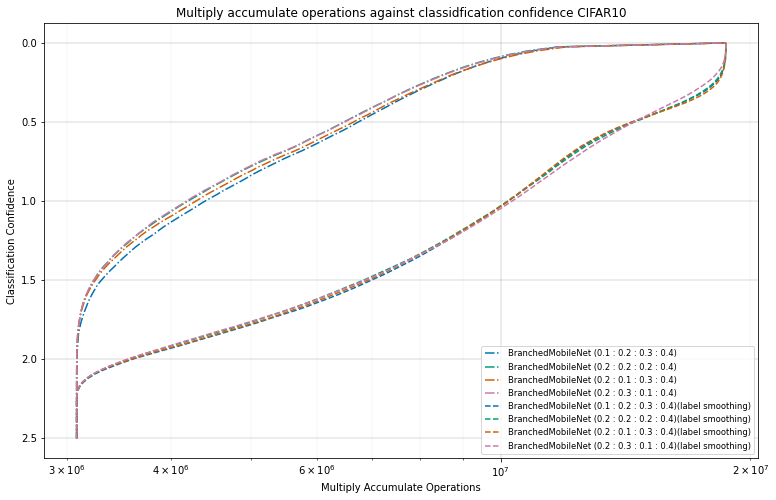

In [ ]:
#CONFIDENCE VS MACs

directory = "../trained-models/BranchedMobileNet/"+dataset+"/CA-"
names = ["wb101-b202-b303","wb102-b202-b302","wb102-b201-b303","wb102-b203-b301"] 

mobile_net_layers = [2,6,10,16,20,36,48,61,79,98,117,135,154,172,191,210,214,218]
mobile_net_branches = [[0,3,4,5],[0,1,3,4,5,6,7,8],[0,1,2,3,4,6,7,8,9,10,11,12]]

colours = ['orangered','seagreen', 'darkmagenta', 'orange']

mobile_labels = list()
mobile_exit_p = list()
mobile_accs = list()

for idx, name in enumerate(names):
    colour = colours[idx]
    plot_directory = directory+name
    accs,MACs,percentages,thresholds,label, branch_accuracies = get_plot_values(plot_directory, mobile_net_layers, mobile_net_branches)
    mobile_exit_p.append(percentages)
    mobile_labels.append(label)
    mobile_accs.append(branch_accuracies)
    plt.plot(MACs[0],thresholds,'-.',label=label)

plt.gca().set_prop_cycle(None)    
directory = "../trained-models/BranchedMobileNet/"+dataset+"/CA-ls-"
names = ["wb101-b202-b303","wb102-b202-b302","wb102-b201-b303","wb102-b203-b301"]

colours = ['orangered','seagreen', 'darkmagenta', 'orange']
res_net_layers = [1,2,3,16,31,46,61,62,63,64]
res_net_branches = [[0,1,2,6],[0,1,2,3,6,7],[0,1,2,3,4,6,7,8]]

resnet_labels = list()
resnet_exit_p = list()
resnet_accs = list()

for idx, name in enumerate(names):
    colour = colours[idx]
    plot_directory = directory+name
    accs,MACs,percentages,thresholds,label, branch_accuracies = get_plot_values(plot_directory, mobile_net_layers, mobile_net_branches)
    resnet_exit_p.append(percentages)
    resnet_labels.append(label)
    resnet_accs.append(branch_accuracies)
    plt.plot(MACs[0],thresholds,'--',label=label+' (label smoothing)')#,color = colour)

#Defining properties of axes
# plt.ylim(0.75,0.95)
plt.xscale('log')
plt.gca().invert_yaxis()
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.grid(which='minor',color='lightgrey', linestyle='--', linewidth=0.3)
plt.title('Multiply accumulate operations against classidfication confidence ' + dataset)
plt.ylabel('Classification Confidence')
plt.xlabel('Multiply Accumulate Operations')
plt.legend(fontsize='small')

#saveplot
plt.savefig('../trained-models/figures/'+dataset+'-thresholds-Macs-ls-comparison.pdf')

#show plot
plt.show()

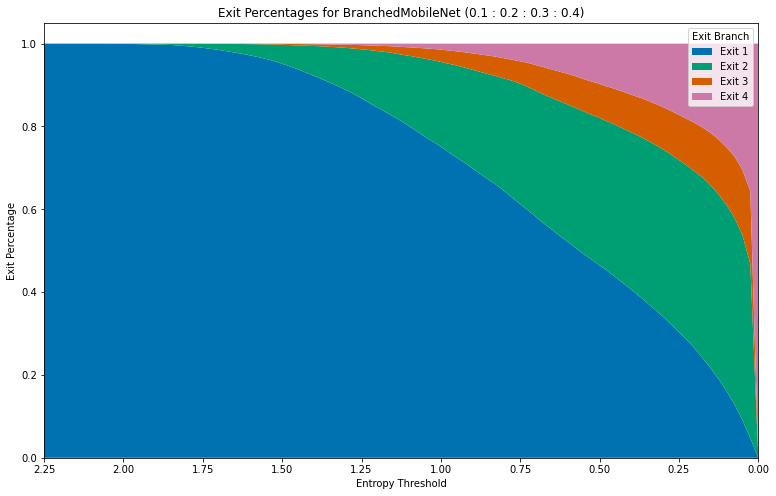

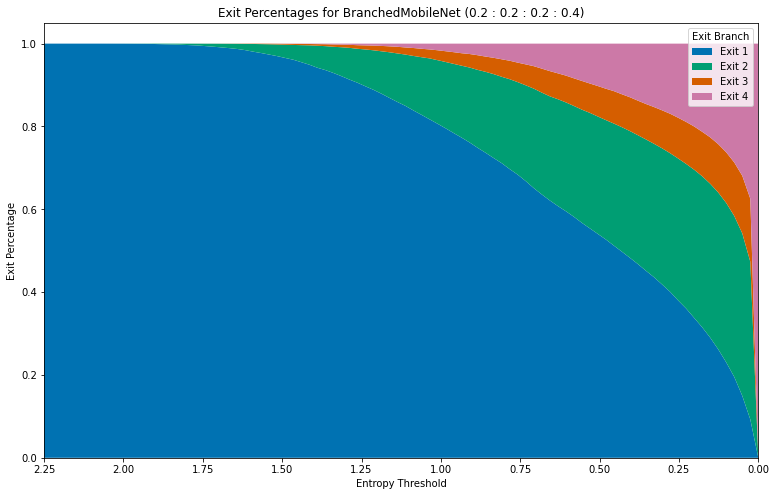

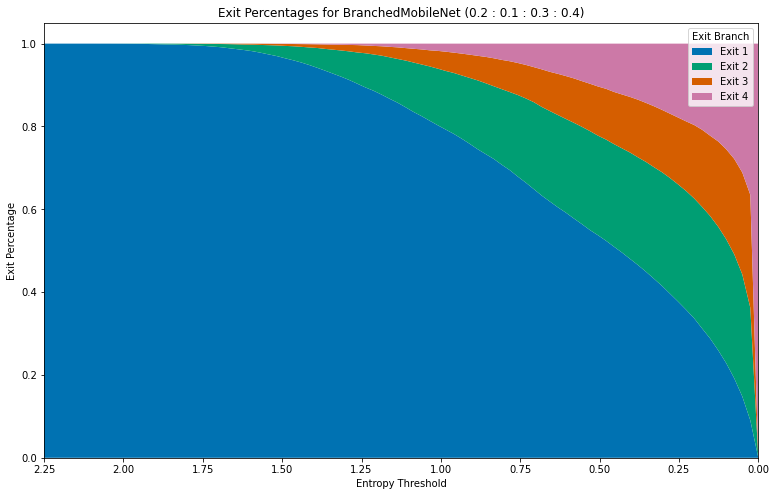

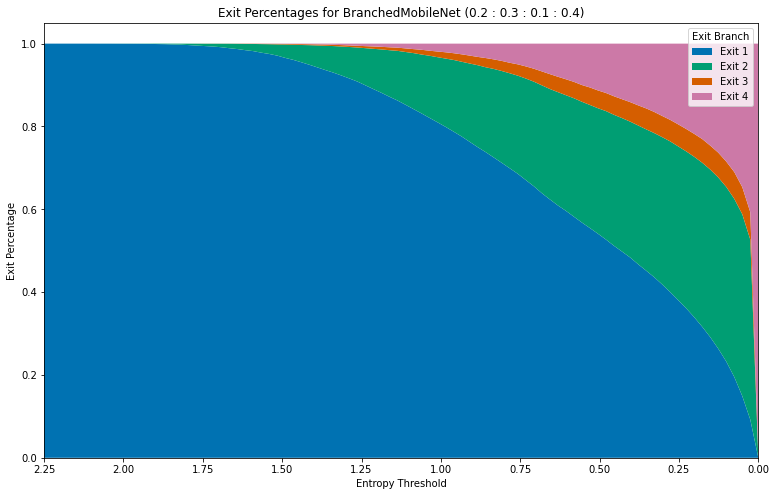

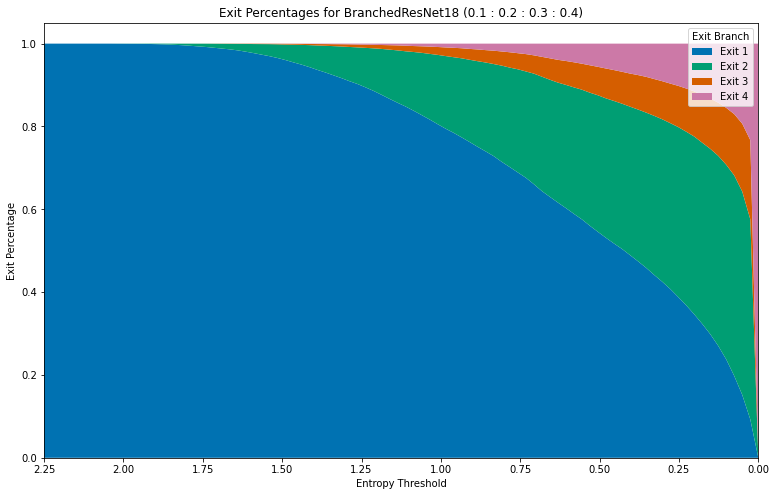

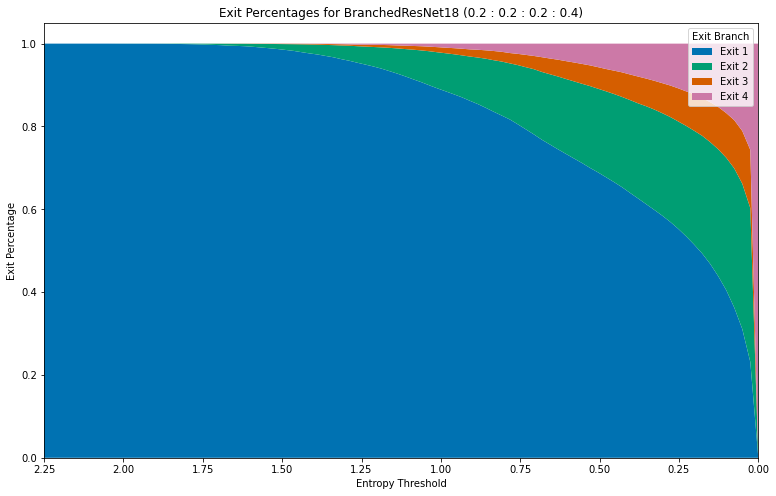

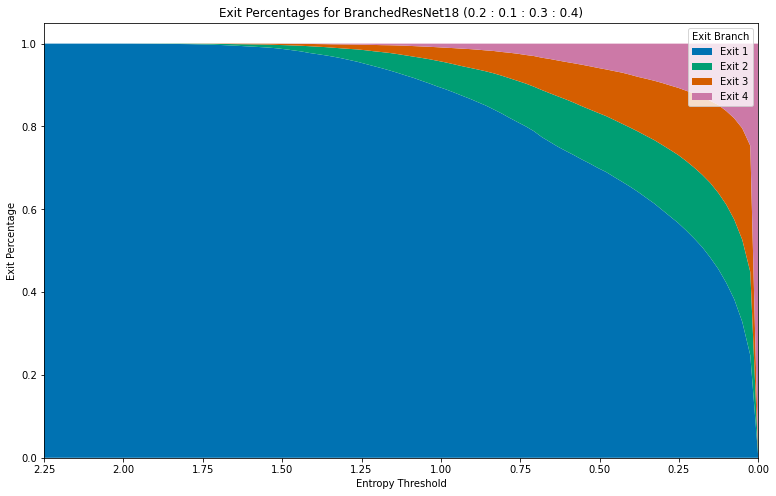

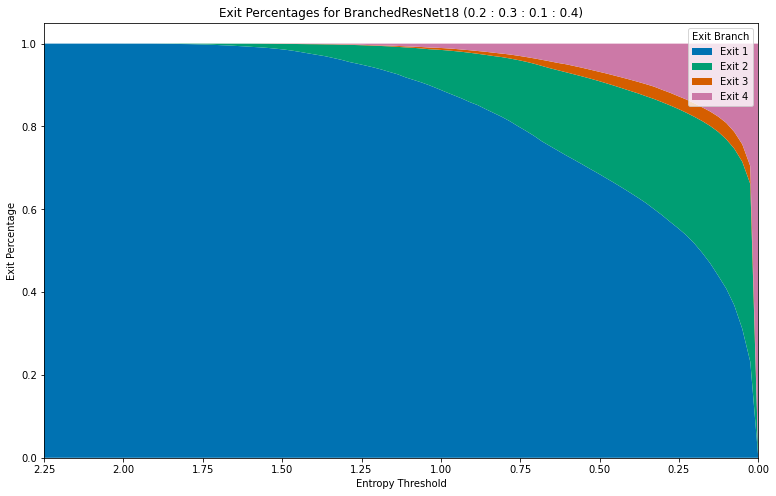

In [ ]:
mobile_exit_p = np.array(mobile_exit_p)
resnet_exit_p = np.array(resnet_exit_p)

for idx, label in enumerate(mobile_labels):
    plt.stackplot(thresholds,mobile_exit_p[idx,:,:].T,labels=['Exit 1','Exit 2','Exit 3','Exit 4'])
    plt.title('Exit Percentages for ' + label)
    plt.xlim(2.25,0)
    plt.ylabel('Exit Percentage')
    plt.xlabel('Entropy Threshold')
    plt.legend(title='Exit Branch')
    if idx == 0:
        plt.savefig('../trained-models/figures/'+dataset+label+'-example.png')
    plt.show()

for idx, label in enumerate(resnet_labels):
    plt.stackplot(thresholds,resnet_exit_p[idx,:,:].T,labels=['Exit 1','Exit 2','Exit 3','Exit 4'])
    plt.title('Exit Percentages for ' + label)
    plt.xlim(2.25,0)
    plt.ylabel('Exit Percentage')
    plt.xlabel('Entropy Threshold')
    plt.legend(title='Exit Branch')
    if idx == 0:
        plt.savefig('../trained-models/figures/'+dataset+label+'example.png')
    plt.show()

In [ ]:
#working out network improvement
def get_decrease(branch_accs):
    decrease = 0
    for inp in range(branch_accs.shape[2]):
        correct = 0
        branch_acc = branch_accs[0,:,inp]
        for branch in branch_acc:
            if branch < correct:
                decrease = decrease + 1
            correct = branch

    return(decrease)

for idx, acc in enumerate(mobile_accs):
    print(mobile_labels[idx],':\t',get_decrease(acc))

for idx, acc in enumerate(resnet_accs):
    print(resnet_labels[idx],' (label smoothing):\t',get_decrease(acc))







BranchedMobileNet (0.1 : 0.2 : 0.3 : 0.4) :	 547
BranchedMobileNet (0.2 : 0.2 : 0.2 : 0.4) :	 534
BranchedMobileNet (0.2 : 0.1 : 0.3 : 0.4) :	 581
BranchedMobileNet (0.2 : 0.3 : 0.1 : 0.4) :	 496
BranchedMobileNet (0.1 : 0.2 : 0.3 : 0.4)  (label smoothing):	 485
BranchedMobileNet (0.2 : 0.2 : 0.2 : 0.4)  (label smoothing):	 527
BranchedMobileNet (0.2 : 0.1 : 0.3 : 0.4)  (label smoothing):	 568
BranchedMobileNet (0.2 : 0.3 : 0.1 : 0.4)  (label smoothing):	 487


In [ ]:
print(mobile_accs)

[array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 1., 1.]],

       [[1., 0., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]]), array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]]), array([[[1., 1., 1., ..., 1., 1., 1.],
        [1